In [155]:
# Change directory to root
import os
from pathlib import Path

# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output
project_root = "./freqtrade"
i=0
try:
    os.chdirdir(project_root)
    assert Path('LICENSE').is_file()
except:
    while i<4 and (not Path('LICENSE').is_file()):
        os.chdir(Path(Path.cwd(), '../'))
        i+=1
    project_root = Path.cwd()
print(Path.cwd())

d:\Downloads\freqtrade-develop


In [156]:
# Load Config
import json
from freqtrade.configuration import Configuration

# Load config from multiple files
config = Configuration.from_files(["config.json"])
#print(config)

# Show the config in memory
#print(json.dumps(config['original_config'], indent=2))

## Start From Here

In [157]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()
from tqdm import tqdm

import sklearn
import xgboost
import catboost
import scipy
import talib.abstract as ta
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### Read Files 

In [158]:
### Helper Functions

def add_features(df):
    """
    This functions takes an OHLC dataframe;
    creates functions and return dataframe
    :params: pandas.DataFrame
    
    :output: pandas.DataFrame
    """
    
    #sc = StandardScaler()
    #df['normclose'] = 10 + sc.fit_transform         (df.close.values.reshape(-1,1))
    #df['logclose'] = np.log(df.normclose)
    #df['sqrtclose'] = np.sqrt(df.normclose)
    
    #sma diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"smadiff_{i}"] = (df['close'].rolling(i).mean() - df['close'])
    #max diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"maxdiff_{i}"] = (df['close'].rolling(i).max() - df['close'])
    #min diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"maxdiff_{i}"] = (df['close'].rolling(i).min() - df['close'])
    #volatiliy
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"std_{i}"] = df['close'].rolling(i).std()
    
    #Return
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"ma_{i}"] = df['close'].pct_change(i).rolling(i).mean()
    
    df['z_score_120'] = ((df.ma_13 - df.ma_13.rolling(21).mean() + 1e-9) 
                         / (df.ma_13.rolling(21).std() + 1e-9))
    
    #Target
    df[ "target"] = df['close'].shift(-7).pct_change(1).rolling(7).mean()
    
    return df
    

In [159]:
headers = ["date", "open", "high", "low", "close", "volume"]

df = []

for file in os.listdir("user_data/data/binance/"):
    if file.endswith("1h.json"):
        filename = os.path.join("user_data/data/binance/", file)
        print(f"Starting read: {filename}")
        d1 = pd.read_json(filename)
        d1.columns = headers
        d1["stock"] = file[:-8]
        d1 = add_features(d1)
        df.append(d1)

df = pd.concat(df)
print("Shape: ", df.shape)

Starting read: user_data/data/binance/AAVE_USDT-1h.json
Starting read: user_data/data/binance/ADA_USDT-1h.json
Starting read: user_data/data/binance/ATOM_USDT-1h.json
Starting read: user_data/data/binance/AVAX_USDT-1h.json
Starting read: user_data/data/binance/BAND_USDT-1h.json
Starting read: user_data/data/binance/BAT_USDT-1h.json
Starting read: user_data/data/binance/BCH_USDT-1h.json
Starting read: user_data/data/binance/BTC_USDT-1h.json
Starting read: user_data/data/binance/BTT_USDT-1h.json
Starting read: user_data/data/binance/BUSD_USDT-1h.json
Starting read: user_data/data/binance/CAKE_USDT-1h.json
Starting read: user_data/data/binance/CHZ_USDT-1h.json
Starting read: user_data/data/binance/DASH_USDT-1h.json
Starting read: user_data/data/binance/DENT_USDT-1h.json
Starting read: user_data/data/binance/DNT_USDT-1h.json
Starting read: user_data/data/binance/DOGE_USDT-1h.json
Starting read: user_data/data/binance/DOT_USDT-1h.json
Starting read: user_data/data/binance/EOS_USDT-1h.json
S

In [160]:
# Format date
df["date"] = pd.to_datetime(df["date"], unit='ms')
df = df.reset_index(drop=True)

<AxesSubplot:>

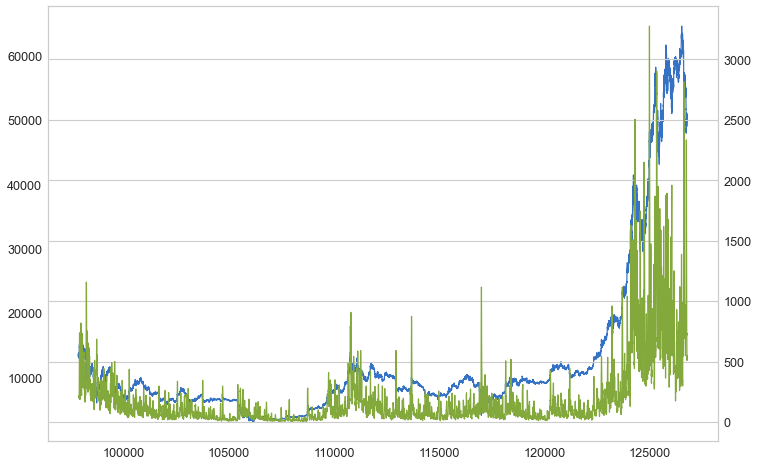

In [161]:
ax = df.loc[df.stock=='BTC_USDT', 'close'].plot(figsize=(12,8))
df.loc[df.stock=='BTC_USDT', 'close'].rolling(30).std().plot(ax=ax, secondary_y=True)

### Feature Engineering 

In [162]:
# Drop new cryptos

stock_size = df.groupby("stock").size().sort_values().reset_index()
stock_size.columns = ["stock", "size"]
uneligible_stocks = stock_size.loc[stock_size["size"] < 241].stock.to_list()

df = df.loc[~df.stock.isin(uneligible_stocks)]

In [163]:
df['time_hourmin'] = df.date.dt.hour * 60 + df.date.dt.minute
df['time_dayofweek'] = df.date.dt.dayofweek
df['time_hour'] = df.date.dt.hour

In [164]:
#df["target"] = df.target / df.meanp_tar
#HOLD

In [165]:
df = df.loc[df.date < '2021-04-10 05:00:00']
print(df.shape)

(869704, 52)


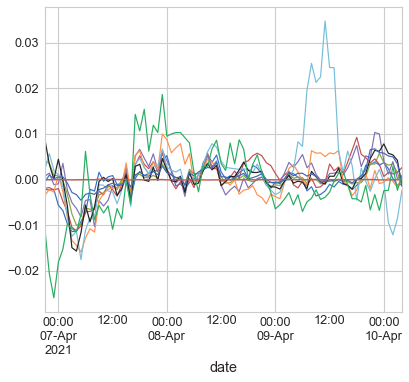

In [166]:
for st in df.stock.unique()[:10]:
    a = df.loc[df.stock==st].set_index("date")
    a.target.tail(80).plot()

<AxesSubplot:>

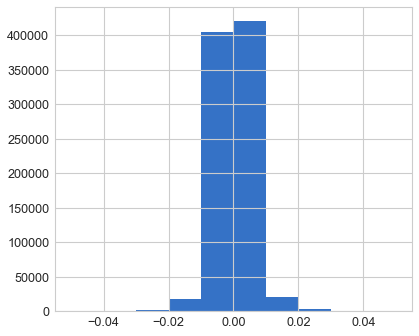

In [167]:
df.target.clip(-0.05,0.05).hist()

In [168]:
df = df.dropna()

In [169]:
df['target'] = pd.qcut(df.target, 5, labels=False)

### Train-Test Split 

In [170]:
df.date.agg(['min', 'max'])

min   2018-01-21 00:00:00
max   2021-04-10 04:00:00
Name: date, dtype: datetime64[ns]

In [171]:

config = {
    'train_split_date': pd.to_datetime('2019-04-09'),
    'val_split_date': pd.to_datetime('2020-11-01'),
    'test_split_date': pd.to_datetime('2021-03-01'),
}

train = df[(df.date >= config['train_split_date']) &
           (df.date < config['val_split_date'])]

val   = df[(df.date >= config['val_split_date']) &
           (df.date < config['test_split_date'])]

test  = df[(df.date >= config['test_split_date'])]

In [172]:
print(train.shape, train.target.mean())
print(val.shape, val.target.mean())
print(test.shape, test.target.mean())

(498936, 52) 1.9768948322029278
(158209, 52) 2.081518750513561
(54769, 52) 2.1348390512881377


In [173]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'stock', 'smadiff_3',
       'smadiff_5', 'smadiff_8', 'smadiff_13', 'smadiff_21', 'smadiff_34',
       'smadiff_55', 'smadiff_89', 'smadiff_120', 'smadiff_240', 'maxdiff_3',
       'maxdiff_5', 'maxdiff_8', 'maxdiff_13', 'maxdiff_21', 'maxdiff_34',
       'maxdiff_55', 'maxdiff_89', 'maxdiff_120', 'maxdiff_240', 'std_3',
       'std_5', 'std_8', 'std_13', 'std_21', 'std_34', 'std_55', 'std_89',
       'std_120', 'std_240', 'ma_3', 'ma_5', 'ma_8', 'ma_13', 'ma_21', 'ma_34',
       'ma_55', 'ma_89', 'ma_120', 'ma_240', 'z_score_120', 'target',
       'time_hourmin', 'time_dayofweek', 'time_hour'],
      dtype='object')

In [174]:
col_not_use = ["date", 'open', 'high', 'low', 'close',
               "target","meanp_tar", 
               "logclose", "sqrtclose", "stock"
              ]
col_use = [c for c in df.columns if c not in col_not_use]

In [175]:
from catboost import CatBoostClassifier

In [176]:
model_return = CatBoostClassifier(iterations=10000,
                          #boosting_type='dart',
                          #random_state=42,
                          #num_leaves=41,
                          learning_rate=0.004,
                          #max_bin =10,
                          task_type='GPU')
model_return.fit(train[col_use], train['target'],
             #eval_metric='binary_error',
             verbose=100,
             #early_stopping_rounds=200,
             eval_set=[(val[col_use], val['target'])],
                )

0:	learn: 1.6090298	test: 1.6089556	best: 1.6089556 (0)	total: 24ms	remaining: 4m
100:	learn: 1.5767729	test: 1.5703277	best: 1.5703277 (100)	total: 2.1s	remaining: 3m 25s
200:	learn: 1.5562598	test: 1.5444821	best: 1.5444821 (200)	total: 4.17s	remaining: 3m 23s
300:	learn: 1.5423080	test: 1.5266392	best: 1.5266392 (300)	total: 6.22s	remaining: 3m 20s
400:	learn: 1.5322276	test: 1.5146456	best: 1.5146456 (400)	total: 8.31s	remaining: 3m 18s
500:	learn: 1.5242941	test: 1.5051123	best: 1.5051123 (500)	total: 10.4s	remaining: 3m 17s
600:	learn: 1.5179101	test: 1.4979428	best: 1.4979428 (600)	total: 12.5s	remaining: 3m 16s
700:	learn: 1.5126933	test: 1.4926881	best: 1.4926881 (700)	total: 14.7s	remaining: 3m 14s
800:	learn: 1.5083104	test: 1.4884539	best: 1.4884539 (800)	total: 16.8s	remaining: 3m 12s
900:	learn: 1.5044111	test: 1.4852063	best: 1.4852063 (900)	total: 18.9s	remaining: 3m 10s
1000:	learn: 1.5009770	test: 1.4825158	best: 1.4825158 (1000)	total: 21s	remaining: 3m 8s
1100:	lear

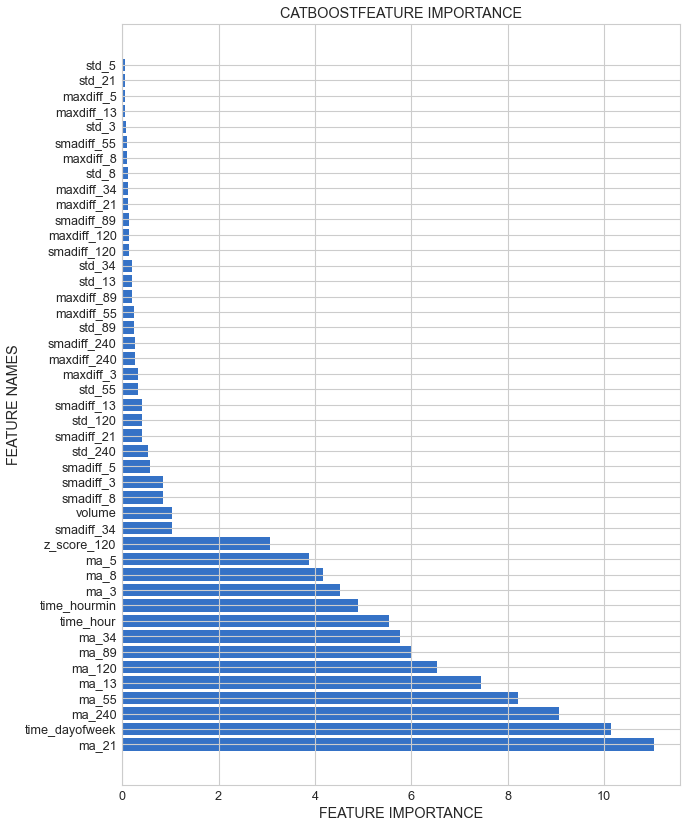

In [177]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(model_return.get_feature_importance(),col_use,'CATBOOST')

In [178]:
preds = pd.DataFrame(model_return.predict_proba(test[col_use]))
from sklearn.metrics import log_loss
print(log_loss(test.target, preds))
preds.columns = [f"pred{i}" for i in range(5)]
preds

1.5007382692223794


,pred0,pred1,pred2,pred3,pred4
0,0.450168,0.144432,0.074903,0.114331,0.216166
1,0.393061,0.169226,0.095142,0.136154,0.206418
2,0.373999,0.187799,0.108561,0.140486,0.189155
3,0.369992,0.203483,0.118639,0.132596,0.175289
4,0.355713,0.202948,0.114922,0.135194,0.191223
...,...,...,...,...,...
54764,0.173841,0.224384,0.185747,0.213029,0.203000
54765,0.235394,0.247917,0.166953,0.167991,0.181745
54766,0.253320,0.263565,0.163795,0.154287,0.165033
54767,0.312119,0.243544,0.138979,0.133597,0.171761


In [179]:
import pickle

with open('user_data/notebooks/model_portfolio.pkl', 'wb') as f:
    pickle.dump([model_return], f)

In [180]:
test = test.reset_index(drop=True)
test = pd.concat([test, preds], axis=1)

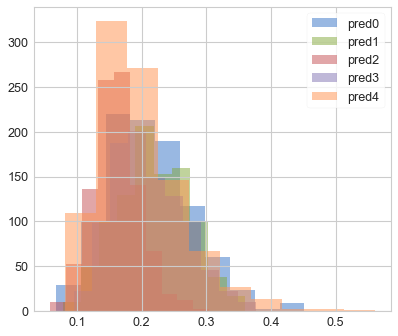

In [181]:
for i in range(5):
    test.groupby("date").tail(1)[f"pred{i}"].hist(alpha=.5, label=f"pred{i}")
plt.legend()

<AxesSubplot:>

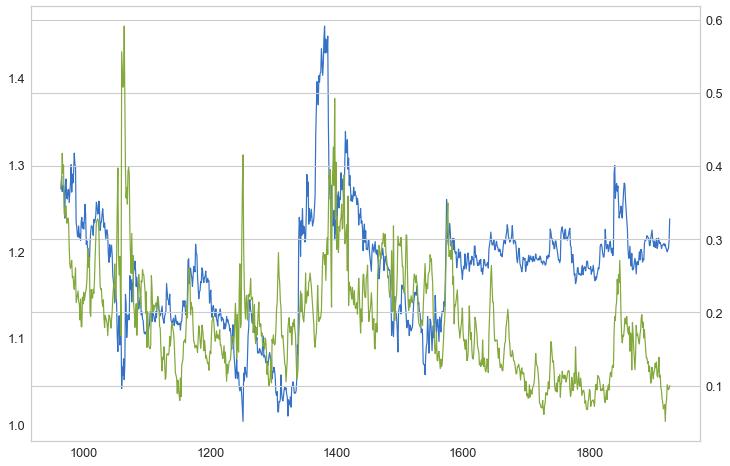

In [182]:
ax = test.loc[test.stock == 'ADA_USDT', 'close'].plot(figsize=(12,8))
test.loc[test.stock == 'ADA_USDT', 'pred4'].plot(ax=ax, secondary_y=True)

In [183]:
test.loc[test.pred4 > .25].stock.unique()

array(['AAVE_USDT', 'ADA_USDT', 'ATOM_USDT', 'AVAX_USDT', 'BAND_USDT',
       'BAT_USDT', 'BCH_USDT', 'BTC_USDT', 'BTT_USDT', 'CAKE_USDT',
       'CHZ_USDT', 'DASH_USDT', 'DENT_USDT', 'DNT_USDT', 'DOGE_USDT',
       'DOT_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT',
       'FTT_USDT', 'HOT_USDT', 'ICX_USDT', 'IOST_USDT', 'IOTA_USDT',
       'LINA_USDT', 'LINK_USDT', 'LTC_USDT', 'LUNA_USDT', 'NANO_USDT',
       'NEO_USDT', 'NKN_USDT', 'NULS_USDT', 'ONT_USDT', 'QTUM_USDT',
       'REEF_USDT', 'RUNE_USDT', 'RVN_USDT', 'SC_USDT', 'SOL_USDT',
       'SUSHI_USDT', 'SXP_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT',
       'VET_USDT', 'VTHO_USDT', 'WIN_USDT', 'WRX_USDT', 'XLM_USDT',
       'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'YFI_USDT', 'ZEC_USDT'],
      dtype=object)

In [184]:
test.date.min()

Timestamp('2021-03-01 00:00:00')

In [185]:
test.loc[test.date == '2021-03-01 00:00:00'].sort_values(by=['pred4'], ascending=False)

,date,open,high,low,close,volume,stock,smadiff_3,smadiff_5,smadiff_8,smadiff_13,smadiff_21,smadiff_34,smadiff_55,smadiff_89,smadiff_120,smadiff_240,maxdiff_3,maxdiff_5,maxdiff_8,maxdiff_13,maxdiff_21,maxdiff_34,maxdiff_55,maxdiff_89,maxdiff_120,maxdiff_240,std_3,std_5,std_8,std_13,std_21,std_34,std_55,std_89,std_120,std_240,ma_3,ma_5,ma_8,ma_13,ma_21,ma_34,ma_55,ma_89,ma_120,ma_240,z_score_120,target,time_hourmin,time_dayofweek,time_hour,pred0,pred1,pred2,pred3,pred4
22891,2021-03-01,0.002437,0.002559,0.002426,0.002533,2.622451e+08,HOT_USDT,-0.000066,-0.000054,-0.000107,-0.000156,-0.000140,-0.000042,0.000086,2.389011e-04,0.000361,0.000218,-0.000107,-0.000107,-0.000333,-0.000333,-0.000333,-0.000333,-0.000333,-0.000333,-0.000333,-0.001051,0.000058,0.000046,0.000117,0.000118,0.000102,0.000162,0.000211,0.000271,0.000317,0.000533,-0.013110,0.084790,0.031819,-0.035400,-0.112209,-0.126228,-0.154470,-0.132998,0.215955,1.100319,2.118721,4,0,0,0,0.394128,0.086581,0.043469,0.070102,0.405720
23855,2021-03-01,1.395800,1.455500,1.383200,1.449500,8.190634e+05,ICX_USDT,-0.037433,-0.035580,-0.059000,-0.073254,-0.053229,0.000500,0.030198,7.944944e-02,0.118825,0.312752,-0.057600,-0.057600,-0.135300,-0.135300,-0.135300,-0.135300,-0.135300,-0.135300,-0.135300,-0.161900,0.032451,0.023276,0.042541,0.040502,0.041994,0.081609,0.077895,0.108858,0.124878,0.302726,0.002135,0.054334,0.004555,-0.053338,-0.092603,-0.048698,-0.101370,-0.086839,-0.184507,0.325408,0.349756,4,0,0,0,0.330784,0.115051,0.052253,0.107278,0.394634
46093,2021-03-01,0.004143,0.004300,0.004123,0.004264,2.072829e+07,VTHO_USDT,-0.000094,-0.000092,-0.000164,-0.000155,-0.000104,-0.000001,0.000120,2.410449e-04,0.000386,0.000991,-0.000146,-0.000146,-0.000427,-0.000427,-0.000427,-0.000427,-0.000427,-0.000427,-0.000427,-0.000427,0.000081,0.000058,0.000149,0.000130,0.000134,0.000179,0.000219,0.000276,0.000350,0.000800,-0.002508,0.045268,-0.022017,-0.040705,-0.070033,-0.063744,-0.090125,-0.165045,-0.198865,0.313813,0.937664,4,0,0,0,0.366538,0.098706,0.049284,0.104382,0.381090
53805,2021-03-01,111.330000,114.220000,110.280000,113.660000,1.298798e+04,ZEC_USDT,-1.536667,-2.068000,-3.752500,-3.270769,-1.940000,1.424412,3.882364,7.065056e+00,9.631667,26.623542,-2.350000,-3.680000,-9.210000,-9.210000,-9.210000,-9.210000,-9.210000,-9.210000,-9.210000,-9.210000,1.331553,1.322108,2.910757,3.085281,3.061019,5.236137,5.413942,7.434633,7.845522,22.942002,0.014918,0.040803,-0.023515,-0.043305,-0.079354,-0.046485,-0.080713,-0.112687,-0.207385,0.012622,0.675049,0,0,0,0,0.274118,0.132299,0.066678,0.145853,0.381052
964,2021-03-01,1.312790,1.322880,1.270000,1.271760,5.967707e+07,ADA_USDT,0.020247,0.031696,0.005478,-0.013131,-0.021280,0.008612,0.022616,-5.469034e-02,-0.103355,-0.175582,0.000000,0.000000,-0.075170,-0.075170,-0.088500,-0.100690,-0.100690,-0.265420,-0.284760,-0.411150,0.020136,0.025996,0.046254,0.045175,0.046889,0.069188,0.075227,0.119375,0.132335,0.131625,-0.009675,0.066680,0.022005,0.010756,-0.074037,0.050154,0.210817,0.200331,0.147821,0.274226,1.655244,3,0,0,0,0.258592,0.137071,0.077163,0.155972,0.371201
26813,2021-03-01,24.695400,25.240400,24.575800,25.219500,2.698958e+05,LINK_USDT,-0.363933,-0.453660,-0.816725,-1.063438,-1.036467,-0.263935,-0.039635,3.063258e-01,0.900371,3.867790,-0.573900,-0.746200,-2.119400,-2.119400,-2.119400,-2.119400,-2.119400,-2.119400,-2.119400,-2.816100,0.316417,0.278620,0.646455,0.632399,0.504737,1.145335,0.977533,1.191970,1.461860,3.971241,0.012267,0.048700,0.017704,-0.027456,-0.068348,-0.018104,-0.057816,-0.112934,-0.177924,-0.023122,0.466318,2,0,0,0,0.292128,0.149565,0.070536,0.156490,0.331281
34525,2021-03-01,4.853000,5.058000,4.824000,4.998000,1.977491e+05,QTUM_USDT,-0.098000,-0.111800,-0.182625,-0.208538,-0.164476,0.008559,0.142055,1.829101e-01,0.226325,0.914229,-0.151000,-0.151000,-0.413000,-0.413000,-0.413000,-0.413000,-0.413000,-0.413000,-0.413000,-0.413000,0.084965,0.064185,0.124098,0.120690,0.114045,0.256238,0.283062,0.274944,0.253666,0.906309,0.011175,0.0462

<AxesSubplot:>

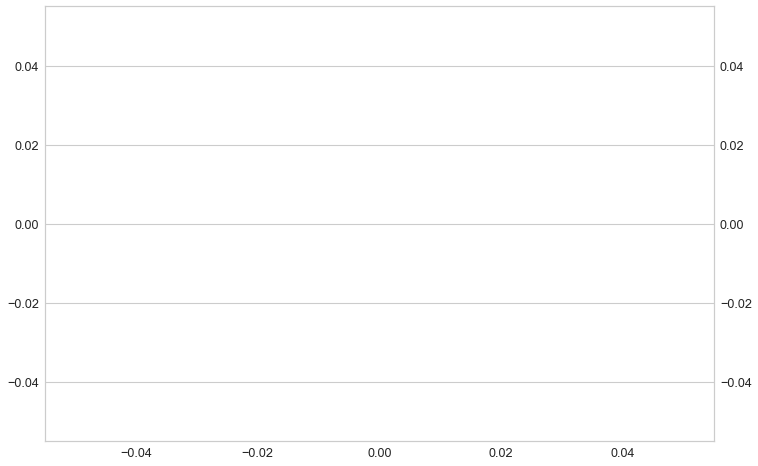

In [186]:
ax = test.loc[test.stock == 'DOGE/USDT', 'close'].plot(figsize=(12,8))
test.loc[test.stock == 'DOGE/USDT', 'pred4'].plot(ax=ax, secondary_y=True)

In [187]:
# SELECT FIRST N ASSET

test["buy"] = 0
for time in test.date.unique():
    stocks = test.loc[test.date == time].sort_values(by=['pred4'], 
                                                     ascending=False)["stock"][:10]
    test.loc[(test.date == time) &
             (test.stock.isin(stocks)), "buy"] = 1

In [188]:
test["buy"] = test["buy"].shift(1)

In [189]:
test["return"] = 1 + (test.close.shift(-1).pct_change())

## Re-Diversified Portfolio in Every 3 Hour

In [190]:
test["return"] = 1 + (test.close.shift(-1).pct_change())

test["return"] = (test["return"] * 
                  test["return"].shift(-1) * 
                  test["return"].shift(-2) *
                  test["return"].shift(-3) * 
                  test["return"].shift(-4)
                 ) 

In [191]:
test["return"].fillna(1.0, inplace=True)

In [192]:
amount = [10000]
benchmark = [10000]

for i, time in enumerate(sorted(test.date.unique())[:-5]):
    if i % 3== 0:
        returns = test.loc[(test.date == time) & (test.buy ==1), "return"].iloc[:10].mean()
        returns -= returns * 0.001
        if np.isnan(returns):
            returns = 1.
        if returns >= 1.5:
            returns = 1.5
        print(len(test.loc[(test.date == time) & (test.buy ==1), "return"]))
        amount.append((amount[-1] * returns) - amount[-1]*0.001)
        benchmark.append((benchmark[-1] * test.loc[(test.date == time), "return"].mean()))
    else:
        continue

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


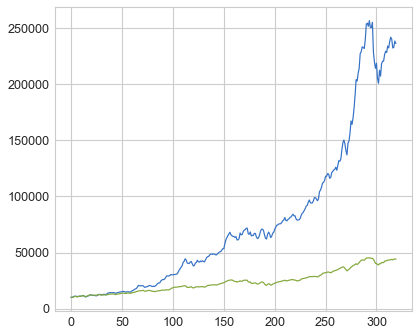

In [193]:
plt.plot(amount[:-1])
plt.plot(benchmark[:-1])

In [194]:
# Weighted portfolio

amount = [10000]
benchmark = [10000]

for i, time in enumerate(sorted(test.date.unique())[:-5]):
    if i % 3== 0:
        returns = test.loc[(test.date == time) & (test.buy ==1)].sort_values(by='pred4')["return"]
        weights = np.array([.3, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
        returns = (returns * weights).sum() / weights.sum()
        #returns -= returns * 0.001
        if returns >= 1.5:
            returns = 1.5
        amount.append((amount[-1] * returns) - amount[-1]*0.001)
        benchmark.append((benchmark[-1] * test.loc[(test.date == time), "return"].mean()))
    else:
        continue

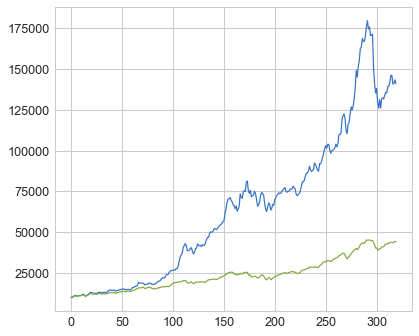

In [195]:
plt.plot(amount[:-1])
plt.plot(benchmark[:-1])

In [196]:
# Approach 2
r = pd.Series(amount).diff()

sr = r.mean()/r.std() * np.sqrt(252 * 24 /3)
print(sr)

7.135534736260564


In [197]:
result = pd.DataFrame()
result["returns"] = pd.Series(amount)

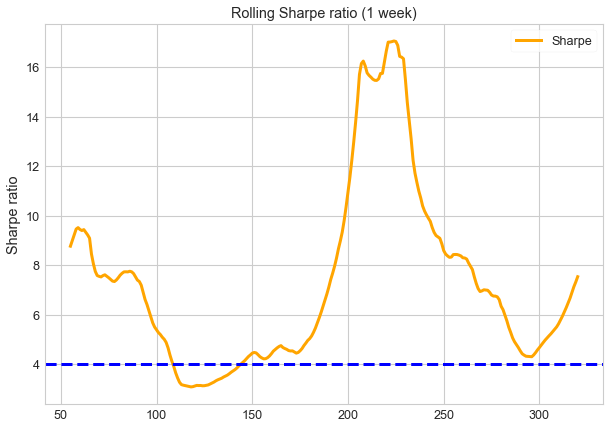

---------------------------------------------------------------
In case you want to check the result data

           returns  rolling_SR
316  140814.275352    6.661440
317  141163.077674    6.893301
318  143417.134257    7.125590
319  141331.316341    7.317480
320  143356.642845    7.531610


In [198]:
result['rolling_SR'] = result.returns.rolling(8*7).apply(lambda x: 
                                                         (x.mean() - 0.02) / x.std(), 
                                                         raw = True)
result.fillna(0, inplace = True)
result[result['rolling_SR'] > 0].rolling_SR.plot(style='-', lw=3, color='orange', 
                                         label='Sharpe', figsize = (10,7))\
                                         .axhline(y = 4., color = "blue", lw = 3,
                                                 linestyle = '--')

plt.ylabel('Sharpe ratio')
plt.legend(loc='best')
plt.title('Rolling Sharpe ratio (1 week)')
plt.show()

print('---------------------------------------------------------------')
print('In case you want to check the result data\n')
print(result.tail()) # I use tail, beacause of the size of your window.